In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
plt.style.use('seaborn-notebook')
import mlflow
import pandas as pd

from mlflow.tracking import MlflowClient

MLFLOW_TRACKING_URI="http://192.168.1.154:5001/"
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

import numpy as np

from ipywidgets import interact

In [2]:
from mlflow.entities import ViewType
names = []
experiments = mlflow.list_experiments(view_type=ViewType.ALL)
for exp in experiments:
    names.append(exp.name)

In [3]:
EXPERIMENT_NAME = "/archimedes-fcnn"

In [4]:
client = MlflowClient()
experiment_id = client.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

In [5]:
# Fetch experiment metadata information
experiment = client.get_experiment(experiment_id)
print("Name: {}".format(experiment.name))
print("Experiment_id: {}".format(experiment.experiment_id))
print("Artifact Location: {}".format(experiment.artifact_location))
print("Tags: {}".format(experiment.tags))
print("Lifecycle_stage: {}".format(experiment.lifecycle_stage))

Name: /archimedes-fcnn
Experiment_id: 11
Artifact Location: gs://mlflow-arts/11
Tags: {}
Lifecycle_stage: active


In [6]:
runs = mlflow.search_runs(experiment_names=[EXPERIMENT_NAME])

In [7]:
runs = mlflow.search_runs(
    experiment_ids=[ experiment_id ],
    filter_string="attribute.status='RUNNING'",
    output_format="list",
)

In [8]:
last_run = mlflow.get_run('0469ad379864486ebd04411c83e12b94')
last_run = runs[-1]

In [9]:
last_run.data.params['filepath'], last_run.data.params['n_classes']

('/data/elekin/data/results/handwriting/tmp/radius_20220912.csv', '3')

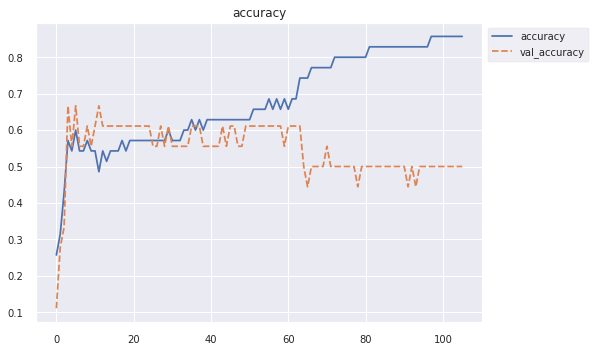

In [10]:
plt.title("accuracy")
plt.plot([i.value for i in client.get_metric_history(last_run.info.run_id, 'accuracy')])
plt.plot([i.value for i in client.get_metric_history(last_run.info.run_id, 'val_accuracy')], linestyle='--')
_=plt.legend(['accuracy','val_accuracy'],bbox_to_anchor=(1.25, 1.))

In [11]:
last_run.data.metrics['accuracy'], last_run.data.metrics['val_accuracy']

(0.8571428656578064, 0.5)

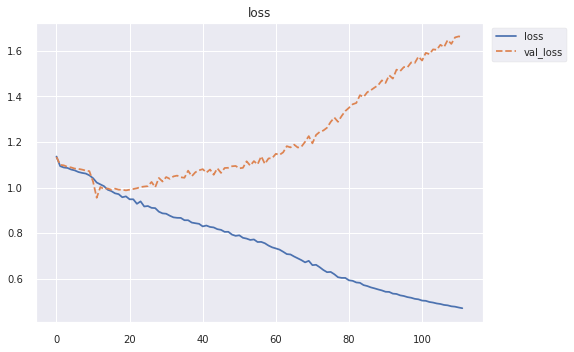

In [12]:
plt.title("loss")
plt.plot([i.value for i in client.get_metric_history(last_run.info.run_id, 'loss')])
plt.plot([i.value for i in client.get_metric_history(last_run.info.run_id, 'val_loss')], linestyle='--')
_=plt.legend(['loss','val_loss'],bbox_to_anchor=(1.2, 1.))

In [13]:
last_run.data.metrics['loss'], last_run.data.metrics['val_loss']

(0.4882015287876129, 1.6270517110824585)

In [14]:
 last_run.data.metrics['val_false_positives']

8.0

In [15]:
cm = np.array([['TP','FP'],['FN','TN']])
cm

array([['TP', 'FP'],
       ['FN', 'TN']], dtype='<U2')

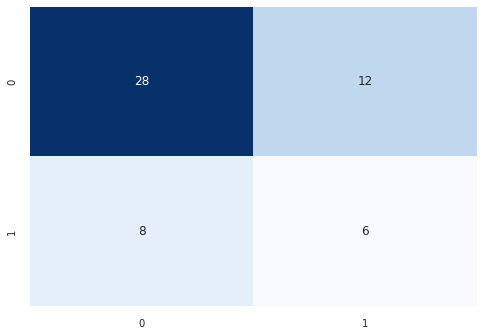

In [16]:
import numpy as np
import matplotlib.pyplot as plt

cm = np.array([[last_run.data.metrics['val_true_negatives'], last_run.data.metrics['val_false_negatives']],
[last_run.data.metrics['val_false_positives'] ,last_run.data.metrics['val_true_positives']]]).astype(np.int32)

_ = sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', cbar=False)

$$ Accuracy: \frac{TP + TN}{TP + TN + FP + FN} $$ 

$$    Recall: \frac{TP}{TP + FN} $$

$$    Precision: \frac{TP}{TP + FP} $$

$$    Specifity: \frac{TN}{TN + FP} $$

Where TP, TN, FP, and FN are, respectively, the true positive, true negative, false positive and false negative values
of the confusion matrix. The positive case corresponds to the ET subjects while the negative case to the CT ones.

**Equations explained**

* Sensitivity/recall – how good a test is at detecting the positives. A test can cheat and maximize this by always returning “positive”. From the whole positive cases how many of them where properly detected.
* Specificity – how good a test is at avoiding false alarms. A test can cheat and maximize this by always returning “negative”.
* Precision – how many of the positively classified were relevant. A test can cheat and maximize this by only returning positive on one result it’s most confident in. 

The cheating is resolved by looking at both relevant metrics instead of just one. E.g. the cheating 100% sensitivity that always says “positive” has 0% specificity.

In [17]:
tn, fp, fn, tp = cm.flatten()
tn, fp, fn, tp

(28, 12, 8, 6)

In [18]:
accuracy = (tp+tn)/(tp+fp+fn+tn)
100 * accuracy

62.96296296296296

In [19]:
#Recall Sensitivity / Specifity
100 * (tp)/(tp+fn), 100 * (tn)/(tn+fp)

(42.857142857142854, 70.0)

In [20]:
# Precission positive / negative
100 * (tp)/(tp+fp), (tn)/(tn+fn)

(33.333333333333336, 0.7777777777777778)